# Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind, ttest_rel
from collections import namedtuple
from recordtype import recordtype

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)

In [2]:
SEED = 0
JOBS = 10

In [3]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Exploration

In [4]:
data = df.read_csv('./data/train_transaction.csv', header=0).set_index('TransactionID')

In [79]:
data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 393 entries, isFraud to V339
dtypes: object(14), float64(376), int64(3)

In [12]:
data['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

## Missing Values

In [56]:
data.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [6]:
X = data[['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']]
y = data['isFraud']
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
npartitions=11,,,,,,,,
2987000,float64,object,int64,float64,float64,object,float64,object
3042696,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
3540477,...,...,...,...,...,...,...,...
3577539,...,...,...,...,...,...,...,...


In [7]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [8]:
X[['card1', 'card2', 'card3', 'card5']] = mean_imp.fit_transform(X[['card1', 'card2', 'card3', 'card5']])
X[['card4', 'card6']] = mode_imp.fit_transform(X[['card4', 'card6']])

In [65]:
X.isnull().sum().compute()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
dtype: int64

## Visualization

In [9]:
y_pos = y[y==1]
y_neg = y[y==0].sample(frac=0.05, random_state=SEED)
X_pos = X.loc[y_pos.index, :]
X_neg = X.loc[y_neg.index, :]

X_p, y_p, y_n = compute(X_pos, y_pos, y_neg)
X_n = compute(X_neg)[0]

<AxesSubplot:xlabel='card6', ylabel='count'>

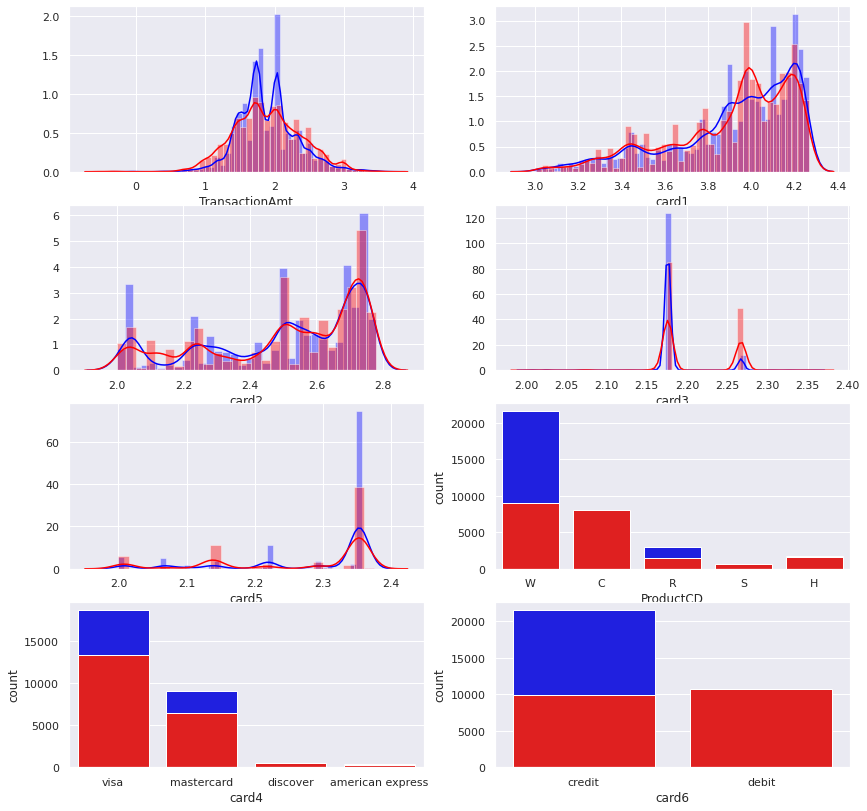

In [10]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,14))
sns.distplot(a=numpy.log10(X_n['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_p['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_n['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_n['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card2']), ax=ax[1,0], color='red')
sns.distplot(a=numpy.log10(X_n['card3']), ax=ax[1,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card3']), ax=ax[1,1], color='red')
sns.distplot(a=numpy.log10(X_n['card5']), ax=ax[2,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card5']), ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_n, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_p, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_n, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_p, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_n, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_p, ax=ax[3,1], color='red')

In [11]:
X = pandas.concat([X_p, X_n]).reset_index(drop=True)
y = pandas.concat([y_p, y_n]).reset_index(drop=True)

In [52]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
0,445.000,W,18268,583.0,150.0,visa,226.0,credit
1,37.098,C,13413,103.0,185.0,visa,137.0,credit
2,37.098,C,13413,103.0,185.0,visa,137.0,credit
3,37.098,C,13413,103.0,185.0,visa,137.0,credit
4,155.521,C,16578,545.0,185.0,visa,226.0,credit


In [221]:
X_ = X.copy()

In [222]:
X_[['ProductCD', 'card4', 'card6']] = X[['ProductCD', 'card4', 'card6']].apply(LabelEncoder().fit_transform)

In [223]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
0,445.000,4,18268,583.0,150.0,3,226.0,0
1,37.098,0,13413,103.0,185.0,3,137.0,0
2,37.098,0,13413,103.0,185.0,3,137.0,0
3,37.098,0,13413,103.0,185.0,3,137.0,0
4,155.521,0,16578,545.0,185.0,3,226.0,0


In [224]:
X_ = MinMaxScaler().fit_transform(X_)

In [225]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

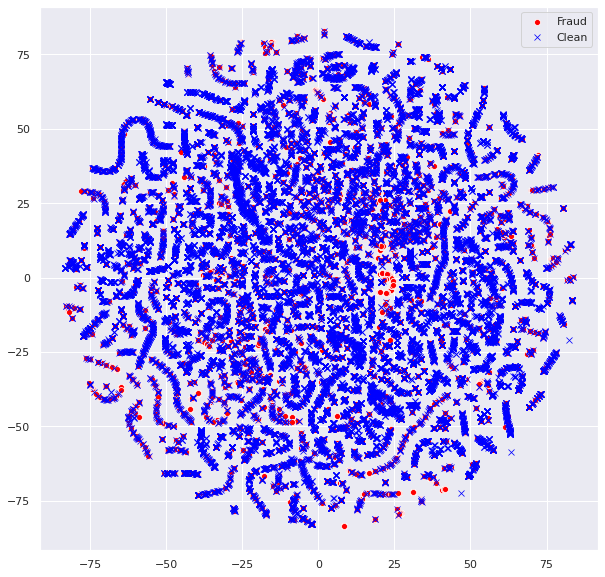

In [226]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_[0:X_pos.shape[0], 0], y=X_[0:X_pos.shape[0], 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_[X_pos.shape[0]:, 0], y=X_[X_pos.shape[0]:, 1], color='blue', marker='x', label='Clean')
plt.legend()

## Feature interaction

In [205]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

tester = Hypot()
mapping = {'card1': 'cont', 'card2': 'cont', 'card3': 'cont', 'card5': 'cont', 'TransactionAmt': 'cont', 'card4': 'cat', 'card6': 'cat', 'ProductCD': 'cat'}

X_[['ProductCD', 'card4', 'card6']] = X[['ProductCD', 'card4', 'card6']].apply(LabelEncoder().fit_transform)
p = tester.test(data=X_, mapping=mapping)

In [215]:
p

,card1,card2,card3,card5,TransactionAmt,card4,card6,ProductCD
card1,1.00000,0.31550,0.00000,0.0,0.04078,0.0,0.0,0.0
card2,0.31550,1.00000,0.00001,0.0,0.00000,0.0,0.0,0.0
card3,0.00000,0.00001,1.00000,0.0,0.00000,0.0,0.0,0.0
card5,0.00000,0.00000,0.00000,1.0,0.00000,0.0,0.0,0.0
TransactionAmt,0.04078,0.00000,0.00000,0.0,1.00000,0.0,0.0,0.0
card4,0.00000,0.00000,0.00000,0.0,0.00000,1.0,0.0,0.0
card6,0.00000,0.00000,0.00000,0.0,0.00000,0.0,1.0,0.0
ProductCD,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.0,1.0


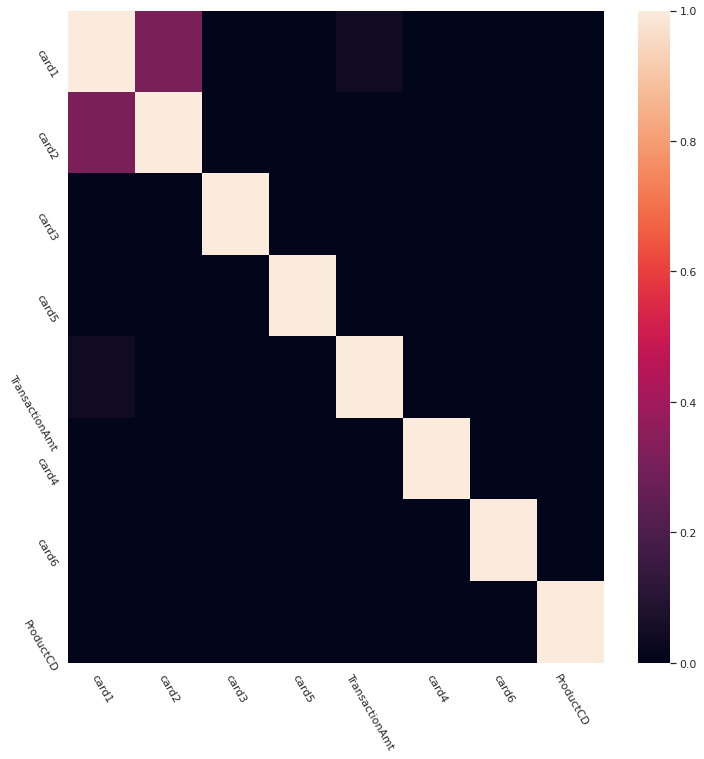

In [206]:
plt.figure(figsize=(12,12))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=300)
plt.xticks(rotation=300)
plt.show()

# Modeling

## Baseline Model

In [53]:
X_ = pandas.get_dummies(X, columns=['card4', 'card6', 'ProductCD'], drop_first=True)

In [54]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,445.000,18268,583.0,150.0,226.0,0,0,1,1,0,0,0,0,0,1
1,37.098,13413,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
2,37.098,13413,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
3,37.098,13413,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
4,155.521,16578,545.0,185.0,226.0,0,0,1,1,0,0,0,0,0,0


In [55]:
X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']]) 

In [56]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2.648360,4.261691,2.765669,2.176091,2.354108,0,0,1,1,0,0,0,0,0,1
1,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
2,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
3,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
4,2.191789,4.219532,2.736397,2.267172,2.354108,0,0,1,1,0,0,0,0,0,0


In [57]:
def ml_pipeline(X, y, n_splits, model, polynomial=False):
    
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, )
    
    if polynomial:
        pol = PolynomialFeatures(interaction_only=True)
        X = pol.fit_transform(X)
        
    Output = recordtype('Output', ['precision', 'recall', 'f1', 'aucPR', 'aucROC','aucs'])
    output = Output(precision=0, recall=0, f1=0, aucPR=0, aucROC=0, aucs=[])
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    for train_index, test_index in cv.split(X, y):
    
        X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]

        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]
    
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred)
        precisions, recalls, _ = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_probs)
        aucROC = roc_auc_score(y_true=y_test, y_score=y_probs)
        aucPR = auc(recalls, precisions)
        
        output.recall += recall
        output.precision += precision
        output.f1 += f1
        output.aucPR += aucPR
        output.aucROC += aucROC
        output.aucs.append(aucPR)
        
        print(f'precision: {precision:0.4f}, recall: {recall:0.4f}, f1: {f1:0.4f}, aucPR: {aucPR:0.4f}, aucROC: {aucROC:0.4f}')
    
    output.recall /= n_splits
    output.precision /= n_splits
    output.f1 /= n_splits
    output.aucPR /= n_splits
    output.aucROC /= n_splits
    
    print(f'Final - precision: {output.precision:0.4f}, recall: {output.recall:0.4f}, f1: {output.f1:0.4f}, aucPR: {output.aucPR:0.4f}, aucROC: {output.aucROC:0.4f}')
    
    return output

In [58]:
model = LogisticRegression(random_state=SEED, n_jobs=JOBS)
output_lr = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.6916, recall: 0.5239, f1: 0.5962, aucPR: 0.6796, aucROC: 0.7449
precision: 0.6815, recall: 0.5394, f1: 0.6022, aucPR: 0.6776, aucROC: 0.7377
precision: 0.6889, recall: 0.5506, f1: 0.6120, aucPR: 0.6809, aucROC: 0.7466
precision: 0.6764, recall: 0.5503, f1: 0.6069, aucPR: 0.6752, aucROC: 0.7476
precision: 0.6697, recall: 0.5358, f1: 0.5953, aucPR: 0.6786, aucROC: 0.7426
precision: 0.6767, recall: 0.5348, f1: 0.5975, aucPR: 0.6822, aucROC: 0.7373
precision: 0.6860, recall: 0.5615, f1: 0.6175, aucPR: 0.6872, aucROC: 0.7522
precision: 0.6766, recall: 0.5470, f1: 0.6049, aucPR: 0.6794, aucROC: 0.7442
precision: 0.6974, recall: 0.5421, f1: 0.6100, aucPR: 0.6890, aucROC: 0.7443
precision: 0.6683, recall: 0.5160, f1: 0.5824, aucPR: 0.6659, aucROC: 0.7347
Final - precision: 0.6813, recall: 0.5401, f1: 0.6025, aucPR: 0.6796, aucROC: 0.7432


## XGBoost

In [59]:
X_ = pandas.get_dummies(X, columns=['card4', 'card6', 'ProductCD'])

In [60]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])

In [61]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2.648360,4.261691,2.765669,2.176091,2.354108,0,0,0,1,0,1,0,0,0,0,0,0,1
1,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,0,1,0,0,1,0,0,0,0
2,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,0,1,0,0,1,0,0,0,0
3,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,0,1,0,0,1,0,0,0,0
4,2.191789,4.219532,2.736397,2.267172,2.354108,0,0,0,1,0,1,0,0,1,0,0,0,0


In [62]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7745, recall: 0.6531, f1: 0.7087, aucPR: 0.7961, aucROC: 0.8498
precision: 0.7580, recall: 0.6744, f1: 0.7138, aucPR: 0.7876, aucROC: 0.8386
precision: 0.7660, recall: 0.6841, f1: 0.7227, aucPR: 0.8106, aucROC: 0.8599
precision: 0.7607, recall: 0.6680, f1: 0.7113, aucPR: 0.7992, aucROC: 0.8497
precision: 0.7563, recall: 0.6563, f1: 0.7028, aucPR: 0.7954, aucROC: 0.8445
precision: 0.7779, recall: 0.6646, f1: 0.7168, aucPR: 0.8073, aucROC: 0.8499
precision: 0.7497, recall: 0.6786, f1: 0.7124, aucPR: 0.7914, aucROC: 0.8419
precision: 0.7712, recall: 0.6854, f1: 0.7258, aucPR: 0.8143, aucROC: 0.8553
precision: 0.7691, recall: 0.6709, f1: 0.7166, aucPR: 0.8067, aucROC: 0.8530
precision: 0.7527, recall: 0.6646, f1: 0.7059, aucPR: 0.7922, aucROC: 0.8415
Final - precision: 0.7636, recall: 0.6700, f1: 0.7137, aucPR: 0.8001, aucROC: 0.8484


In [276]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model, polynomial=True)

precision: 0.7560, recall: 0.6730, f1: 0.7121, aucPR: 0.7999, aucROC: 0.8475
precision: 0.7539, recall: 0.6715, f1: 0.7103, aucPR: 0.7897, aucROC: 0.8428
precision: 0.7636, recall: 0.6812, f1: 0.7200, aucPR: 0.8113, aucROC: 0.8524
precision: 0.7474, recall: 0.6675, f1: 0.7052, aucPR: 0.7906, aucROC: 0.8437
precision: 0.7618, recall: 0.6810, f1: 0.7191, aucPR: 0.7934, aucROC: 0.8472
precision: 0.7531, recall: 0.6554, f1: 0.7008, aucPR: 0.7948, aucROC: 0.8411
precision: 0.7631, recall: 0.6859, f1: 0.7224, aucPR: 0.8046, aucROC: 0.8499
precision: 0.7563, recall: 0.6864, f1: 0.7196, aucPR: 0.7972, aucROC: 0.8457
precision: 0.7746, recall: 0.6820, f1: 0.7254, aucPR: 0.8176, aucROC: 0.8582
precision: 0.7742, recall: 0.6786, f1: 0.7232, aucPR: 0.8123, aucROC: 0.8600
Final - precision: 0.7604, recall: 0.6762, f1: 0.7158, aucPR: 0.8011, aucROC: 0.8489


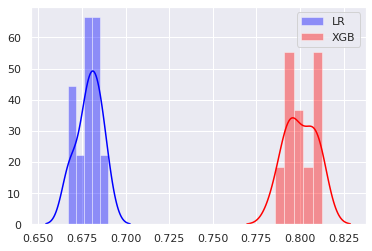

In [237]:
plt.figure()
sns.distplot(output_lr.aucs, color='blue', bins=5, label='LR')
sns.distplot(output_xgb.aucs, color='red', bins=5, label='XGB')
plt.legend()

In [238]:
ttest_rel(output_lr.aucs, output_xgb.aucs)

Ttest_relResult(statistic=-57.36225013499823, pvalue=7.488282697339015e-13)

## Feature Expansion

In [12]:
C_family = data.loc[:, 'C1':'C14']

In [13]:
C_pos = C_family.loc[y_pos.index, :]
C_neg = C_family.loc[y_neg.index, :]

In [14]:
C_p = compute(C_pos)[0]
C_n =compute(C_neg)[0]

In [ ]:

f, ax = plt.subplots(nrows=7, ncols=2, figsize=(12,30))

feature = 1
for row in range(0, 7):
    for col in range(0, 2):
        sns.distplot(numpy.log10(C_p[f'C{feature}'].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(C_n[f'C{feature}'].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        feature += 1
    